# Predicting Spotify Song Popularity

Taylor Willingham<br>
June 2019

## Introduction

This is a capstone project centered on the task of predicting popular songs through machine learning. In order to train and test such a model, this particular project utilizes data originating from the Spotify API. Although this capstone specifically uses custom metrics as determined by Spotify, the hope is that the concepts explored here could perhaps be generalized for broader use. This notebook and, more broadly, its corresponding github repository cover the steps followed, as well as the project findings. 

## Table of Contents
1. [Overview](#overview)
2. [Exploring the Data](#init)
3. [Modeling](#modeling)
4. [Conclusions](#conclusions)

## Overview
<a id=overview></a>

<b>Overview of the Problem:</b> The music marketplace is a fickle place. Artists that once topped the charts fall out of favor, while new artists may unexpectedly take the spotlight. There never seems to be much of a pattern and, regardless of what any one person may know, it’s practically impossible to predict which songs will make the cut.<br>

With that in mind, if we take the task of prediction out of the hands of the decision makers and turn it over instead to a predictive model, perhaps the model can find a pattern that humans might overlook. By knowing which songs are popular on Spotify and the characteristics of those songs, perhaps we can find correlations algorithmically that will provide a little more certainty when choosing the next ‘hit’.<br>

<b>Client:</b> It’s important to clarify that the goal of this capstone project is not to make personal recommendations. This is not guided by the tastes of a specific user in order to make suggestions for that user. Rather, this project looks at popular songs in a collective sense, as determined by the general population. As such, the intended target is more along the lines of a music programmer or an A&R executive: someone who would benefit from knowing which songs will have the most impact. These decision makers choose which songs to promote based on what they think will most likely hold a listener’s attention, and any tool that can help them improve their accuracy will help them to be more effective in that role.<br>

<b>Data:</b> The data for this project originates from a Kaggle dataset that can be found here: https://www.kaggle.com/tomigelo/spotify-audio-features<br>

Each observation represents an individual song, and there are approximately 130,000 rows. There are 17 columns in the dataset, the majority of which contain numerical values providing a score on various musical qualities. Some examples include: loudness, instrumentalness, danceability, liveness and the like. Finally, the last column, the target column, lists a popularity score between 0 and 100 for each song.<br>

<b>Approach:</b> To use either a classification algorithm or a linear regression model to determine a song’s popularity given the input variables of its descriptors. If we leave the target variable as scalar and attempt to predict a song’s exact popularity score, then a regression model will work best. On the other hand, if we split popularity into two classes, popular or unpopular, based on an arbitrary demarcation, then we could use a classification model.

## Exploring the Data
<a id=init></a>

### Load in the data and packages

In [2]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

<b>Shaping the data</b><br>
In order to get the dataset into a format suitable for analysis, the observations will be sorted by their popularity scores, and the index will start from 1 in order know exactly where songs rank. This is just for exploratory purposes, and the data will be re-shuffled later to try to avoid any unintented bias with the machine learning models.<br>
<br>
A significant adjustment is that all songs with a populartiy of zero will be dropped. This decision was made because of the low barrier of entry for songs to be hosted on Spotify, and the hope is that by removing these observations we can cut down on the noise in the dataset.<br>
<br>
For more insight into these and other decisions regarding data restructuring, refer to the data wrangling notebook in the Reports sub-folder of this repository, which can be found here: <a>https://github.com/twillstw/Spotify-Popularity-Prediction/blob/master/Reports/1.%20Data%20Wrangling.ipynb</a>

In [106]:
#load data
spotify = pd.read_csv('Data/SpotifyFeatures0419.csv')

# Create the sorted dataframe, drop zeros, convert any categoricals
sort_data = spotify.sort_values('popularity', ascending=False).reset_index()
spotify_ordered = sort_data.drop(['index', 'track_id'], axis=1)
spotify_ordered.index = spotify_ordered.index + 1

spotify_ordered = spotify_ordered[spotify_ordered.popularity > 0]

spotify_ordered[['mode', 'key', 'time_signature']] = \
    spotify_ordered[['mode', 'key', 'time_signature']].astype('category')

In [107]:
# Inspect the shape
spotify_ordered.shape

(111774, 16)

After dropping all of the observations with a popularity of zero, roughly 111,800 rows remain. Furthermore, there are 15 features and one target variable. Looking at the first few rows shows the types of features and gives a sense of how the data is sorted.

In [5]:
# Inspect the first few observations
spotify_ordered.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1,Daddy Yankee,Con Calma,0.1100,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.656,100
2,Post Malone,Wow.,0.1630,0.833,149520,0.539,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,0.385,98
3,Billie Eilish,bad guy,0.3080,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.578,98
4,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,0.5200,0.744,158040,0.494,0.000000,2,0.0716,-5.563,1,0.0699,89.972,4,0.927,98
5,Jonas Brothers,Sucker,0.0427,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.952,98


<b>Adding a new column</b><br>
The way the target variable is set up, the data set lends itself towards a regression problem. However, with a bit of manipulation, the popularity scores can be binned in order to also explore classification.

In [108]:
#Create table with a column classifying popularity ratings
classified = spotify_ordered.copy()
classified['pop_rating'] = ''

for i, row in classified.iterrows():
    score = 'unpopular'
    if (row.popularity > 50) & (row.popularity < 75):
        score = 'medium'
    elif row.popularity >= 75:
        score = 'popular'
    classified.at[i, 'pop_rating'] = score

In [7]:
# Inspect the new column
classified[['track_name', 'popularity', 'pop_rating']].head(3)

,track_name,popularity,pop_rating
1,Con Calma,100,popular
2,Wow.,98,popular
3,bad guy,98,popular


### Visual EDA

First, here's a plot to visualize the distribution of the target variable values.

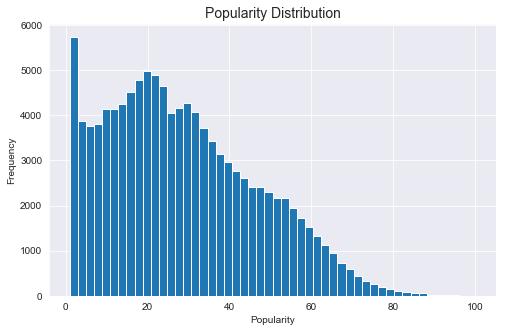

In [8]:
# Inspect shape of popularity variable
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = spotify_ordered['popularity'].plot(kind='hist', bins=50)
_ = plt.xlabel('Popularity')
_ = plt.title('Popularity Distribution', fontsize=14)

Even with the zero values dropped, the popularity scores are heavily weighted towards the bottom of the scale, and the distribution tapers off severely as it moves towards the higher popularity values.

<b>Correlations</b><br>
Having briefly examined the target variable, it's now useful to examine the rest of the features and see how they correlate with each other, in particular the values for the popularity column.

In [9]:
# Generat correlation table
spotify_ordered.corr()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
acousticness,1.000000,-0.359877,0.049087,-0.737737,0.320986,-0.113883,-0.631248,-0.125848,-0.218866,-0.182997,-0.152114
danceability,-0.359877,1.000000,-0.147489,0.294570,-0.341741,-0.119567,0.443299,0.251208,0.063790,0.457178,0.194267
duration_ms,0.049087,-0.147489,1.000000,-0.041508,0.073682,-0.006783,-0.049664,-0.115628,-0.017789,-0.157237,-0.038537
energy,-0.737737,0.294570,-0.041508,1.000000,-0.336212,0.205073,0.782896,0.111446,0.235635,0.323009,0.151448
instrumentalness,0.320986,-0.341741,0.073682,-0.336212,1.000000,-0.070851,-0.527086,-0.213433,-0.099311,-0.282644,-0.201522
liveness,-0.113883,-0.119567,-0.006783,0.205073,-0.070851,1.000000,0.072658,0.114989,0.001880,0.011129,-0.039396
loudness,-0.631248,0.443299,-0.049664,0.782896,-0.527086,0.072658,1.000000,0.072990,0.227240,0.329304,0.272248
speechiness,-0.125848,0.251208,-0.115628,0.111446,-0.213433,0.114989,0.072990,1.000000,0.050433,0.129835,0.009084
tempo,-0.218866,0.063790,-0.017789,0.235635,-0.099311,0.001880,0.227240,0.050433,1.000000,0.096504,0.046398
valence,-0.182997,0.457178,-0.157237,0.323009,-0.282644,0.011129,0.329304,0.129835,0.096504,1.000000,0.045007


Now to visualize the correlations:

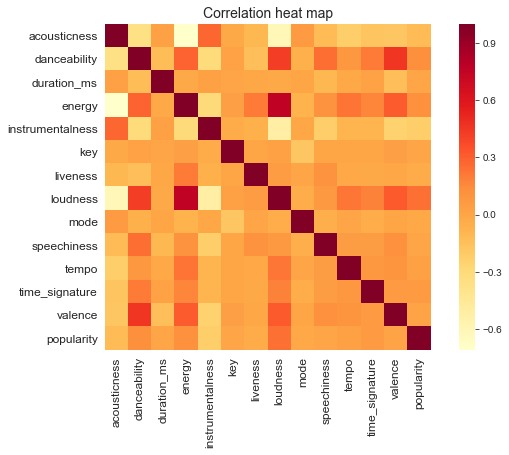

In [10]:
# Generate heat map using seaborn
fig, ax = plt.subplots(1,1, figsize=(10,6))
_ = sns.heatmap(spotify.corr(), square=True, cmap='YlOrRd')
_ = plt.title('Correlation heat map', fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

The correlations are mostly pretty weak.

<b>Further examining specific variables</b>

Various plots can be used to examine the relationship between certain dataset features and the target variable. Below, two functions are defined in order to create multiple plots.

In [11]:
def scat_plot(x, y, hue=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.scatterplot(x, y, hue=hue, s=12)
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.legend(fontsize=12)
    plt.show()
    
    
def regress_plot(x='', y='', data=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot with a regression line
    using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.regplot(x, y, data=data, scatter_kws={"s": 10}, line_kws={'color':'r'})
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.ylim(-3, 103)
    plt.show()

Using the scat_plot function to visualize the loudness feature.

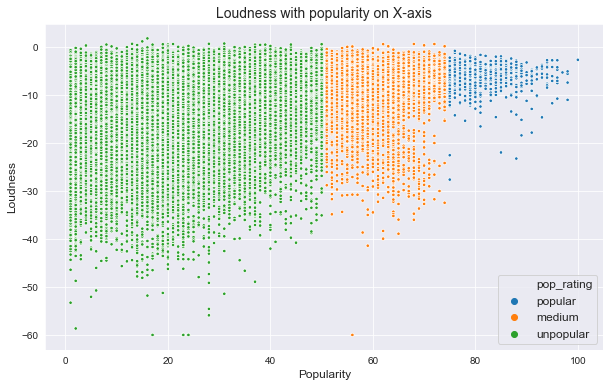

In [14]:
s = spotify_ordered

# Use the scat_plot function to plot loudness against popularity
scat_plot(s.popularity, s.loudness, hue=classified.pop_rating, xlab='Popularity',\
         ylab='Loudness', titl='Loudness with popularity on X-axis')

Now with the regress_plot function:

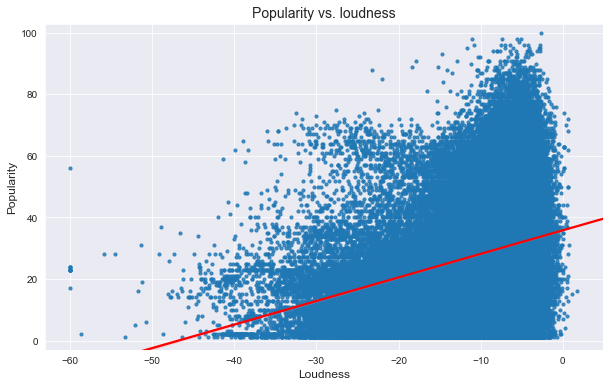

In [16]:
regress_plot('loudness', 'popularity', data=s, xlab='Loudness',\
         ylab='Popularity', titl='Popularity vs. loudness')

Using subplots to examine multiple features; in this case, energy and danceability:

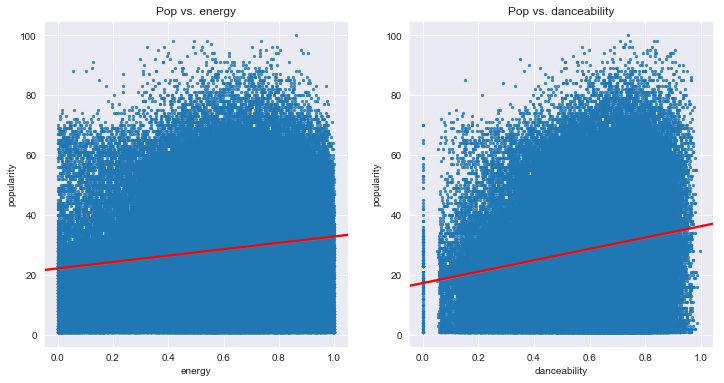

In [17]:
# Subplots with energy and danceability
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,2,1)
_ = sns.regplot(s.energy, s.popularity, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Pop vs. energy')

ax2 = plt.subplot(1,2,2)
_ = sns.regplot(s.danceability, s.popularity, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Pop vs. danceability')

## Modeling
<a id=modeling></a>

Remove: Shakira, Jonas Brothers, Tame Impala, the Weekend

In [109]:
# Artists to use for test cases
artists = ['Shakira', 'Jonas Brothers', 'Tame Impala', 'The Weeknd']

# Create a list of indices corresponding to the artists above
# The first comprehension creates a list of lists, the second flattens it into one
to_drop = [classified[classified.artist_name == name].index.tolist() for name in artists]
to_drop = [ind for sub in to_drop for ind in sub]

# Gather the test cases
df_x = classified.copy()
cases = df_x[df_x.index.isin(to_drop)]

# Remove the test cases from data
classified.drop(to_drop, inplace=True)
spotify_ordered.drop(to_drop, inplace=True)

In [111]:
# Original row count was 111,774. Check new shape
print(classified.shape)
print(spotify_ordered.shape)

(111762, 17)
(111762, 16)


##### Linear Regression

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Set random state
state=25

# Shuffle the data
reg_data = spotify_ordered.sample(frac=1, random_state=state).reset_index(drop=True)

# First, try without categoricals
X = reg_data.select_dtypes(include='number').drop('popularity', axis=1)
y = reg_data.popularity

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)

In [139]:
%%time
# Instantiate and fit model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict and check score
print(linreg.score(X_test, y_test))

0.09785133473998608
Wall time: 35.7 ms


The score for the model above is not very good. Let's see what happens when using the categoricals by using one hot encoding with .get_dummies(). For this step, I have decided to drop the artist_name column. While song popularity is often correlated with artist popularity, the hope is for this model to work just as well on an artist it hasn't seen before. Part of the goal is to be able to discover new talent, and that becomes more difficult if the algorithm is inclined to discredit a song just because it doesn't recognize the artist. Therefore, the column will be dropped for training purposes.

In [140]:
no_artist = reg_data.drop(['artist_name', 'track_name'], axis=1)
df_encoded = pd.get_dummies(no_artist)
df_encoded.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_0', 'mode_1', 'time_signature_0', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [141]:
# Do a new split and run a new linear model
XX = df_encoded.drop('popularity', axis=1)
yy = df_encoded.popularity

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.25, random_state=state)

In [142]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))

0.0993840543915483
Wall time: 124 ms


The results are only marginally beter.

##### Rigde regression

In [143]:
%%time
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5, normalize=True)
ridge.fit(X_train, y_train)

print(ridge.score(X_test, y_test))

0.08705278469931688
Wall time: 187 ms


#### Classification

The different classes in the classified dataset exhibit a high level of imbalance. This needs to be accounted for in order to ensure the models perform as well as possible. 

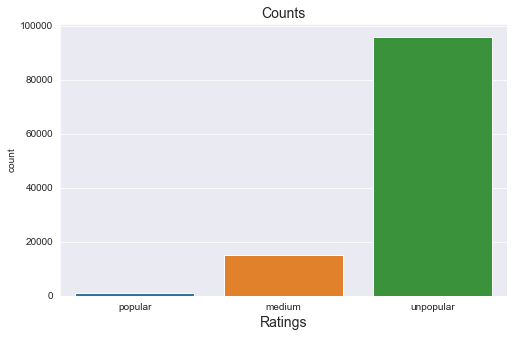

In [156]:
# simple count of the ratings
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = sns.countplot(x='pop_rating', data=classified)
_ = plt.xlabel('Ratings', fontsize=14)
_ = plt.title('Counts', fontsize=14)

##### Creating a balanced sample for the final test set.

In [145]:
# Don't want artist name and need to drop track_name
# Need to encode the categorical variables, but not target column
df = classified.drop(['artist_name', 'track_name'], axis=1)
df = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'])
df.shape

(111762, 31)

In [144]:
#df.columns

In [146]:
from sklearn.model_selection import train_test_split

df_pop = df[df.pop_rating == 'popular']

df_med = df[df.pop_rating == 'medium']

df_unpop = df[df.pop_rating == 'unpopular']

# Set random seed
state=25


# splits: X is features minus popularity, y is pop_rating; test size = ?
X_tr_p, X_ts_p, y_tr_p, y_ts_p = train_test_split(df_pop.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_pop.pop_rating, test_size=0.15, random_state=state)

X_tr_m, X_ts_m, y_tr_m, y_ts_m = train_test_split(df_med.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_med.pop_rating, test_size=0.15, random_state=state)

X_tr_up, X_ts_up, y_tr_up, y_ts_up = train_test_split(df_unpop.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_unpop.pop_rating, test_size=0.15, random_state=state)

In [147]:
# Merge all of the X & y train variables
# Then concatenate into one training set
pop_train = pd.concat([X_tr_p, y_tr_p], axis=1)
med_train = pd.concat([X_tr_m, y_tr_m], axis=1)
unpop_train = pd.concat([X_tr_up, y_tr_up], axis=1)

training = pd.concat([pop_train, med_train, unpop_train], axis=0)

# Take sample of whole training set to shuffle the rows
training = training.sample(frac=1, random_state=state).reset_index(drop=True)

# Popularity has been removed, so only 30 columns
training.shape

(94997, 30)

In [148]:
# Same process for the test data
pop_test = pd.concat([X_ts_p, y_ts_p], axis=1)
med_test = pd.concat([X_ts_m, y_ts_m], axis=1)
unpop_test = pd.concat([X_ts_up, y_ts_up], axis=1)

final_test = pd.concat([pop_test, med_test, unpop_test], axis=0)

final_test = final_test.sample(frac=1, random_state=state).reset_index(drop=True)

final_test.shape

(16765, 30)

In [149]:
training.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5',
       'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_0',
       'mode_1', 'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'pop_rating'],
      dtype='object')

##### Models

In [150]:
# Imports and split the train and validation sets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_class = training.drop('pop_rating', axis=1)
y_class = training.pop_rating

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.25, random_state=state)

##### Decision Tree

In [151]:
%%time

# Basic decision tree
dt = DecisionTreeClassifier(max_depth=20, random_state=state)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(accuracy_score(pred, y_test))

0.7930105263157895
Wall time: 2.25 s


##### Bagging

In [152]:
%%time

from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(max_depth=20, random_state=state)
bc = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=state)

bc.fit(X_train, y_train)

b_pred = bc.predict(X_test)

print(accuracy_score(b_pred, y_test))

0.8597052631578948
Wall time: 2min 33s


##### Random Forest

In [153]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=state)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.8606736842105264
Wall time: 34.6 s


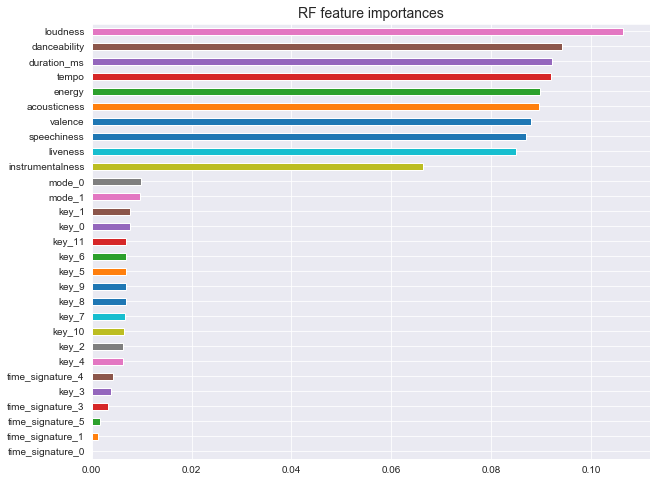

In [160]:
important = pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots(figsize=(10,8))
_ = important.plot(kind='barh')
_ = plt.title('RF feature importances', fontsize=14)

## Conclusions
<a id=conclusions></a>

#### Linear Regression Results

| Algorithm                             | Score | Execution Time |
|:---------------------------------------|-------|----------------|
|  Linear Regression - No categoricals  | 0.098 | 35.7 ms        |
| Linear Regression - With categoricals | 0.099 | 124 ms         |
| Ridge Regression                      | 0.087 | 187 ms         |

#### Classification Results

| Algorithm     | Accuracy | Execution Time |
|---------------|----------|----------------|
| Decision Tree | 0.793    | 2.25 s         |
| Bagging       | 0.860    | 2 min 33 s     |
| Random Forest | 0.861    | 34.6 s         |